In [32]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import  Statevector, random_statevector, SparsePauliOp
from qiskit.visualization import plot_bloch_multivector
from qiskit_experiments.library.tomography import StateTomography
from qiskit.primitives import Estimator
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel, amplitude_damping_error
from qiskit.providers.fake_provider import FakeVigo

**Exercise 2**

In [33]:
def EPR(id='00'):    
    circ = QuantumCircuit(2)
    if id[1] == '1':
        circ.x(0)
    if id[0] == '1':
        circ.x(1)    
    circ.h(0)
    circ.cx(0, 1)
    return circ

**Exercise 3**

In [34]:
def teleport(statevector):
    circ = QuantumCircuit(3, 2)
    # init state to be teleported
    circ.initialize(statevector, 0)
    # init Bell state
    circ.h(1)
    circ.cx(1, 2)
    circ.barrier()
    # start teleportation protocol
    circ.cx(0, 1)
    circ.h(0)
    circ.barrier()
    circ.measure([0, 1], [0, 1])
    circ.z(2).c_if(0, 1)
    circ.x(2).c_if(1, 1)
    return circ

In [35]:
Ψ = random_statevector(2) 
circ = teleport(Ψ)
circ.save_statevector()
#print(circ.draw(cregbundle=False))

sim = AerSimulator(method="statevector")
Ψ_out = sim.run(circ).result().get_statevector()

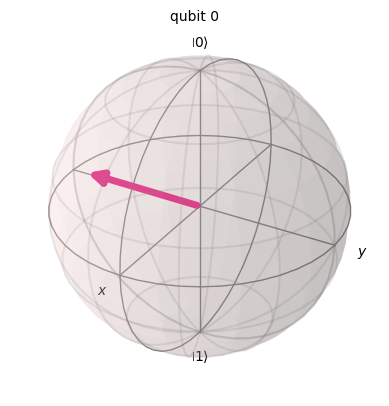

In [36]:
plot_bloch_multivector(Ψ)

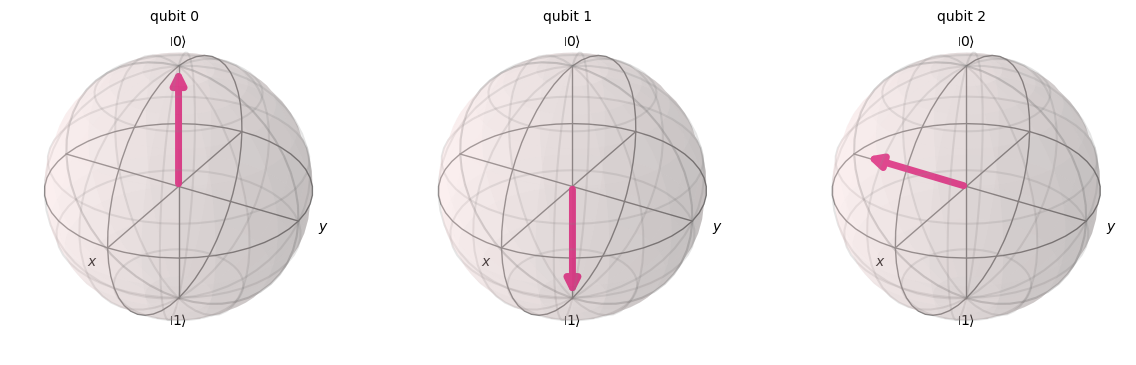

In [37]:
plot_bloch_multivector(Ψ_out)

**Exercise 5**

In [38]:
def time_evolve(circ, t, dt, w, w0, w1):
    N = round(t/dt)
    for n in range(N):
        circ.rx(2*w1*dt*np.cos(w*n*dt), 0)
        circ.rz(-w0*dt, 0)
    return circ

In [39]:
def plot_β_time_evolution(ts, dt, w, w0, w1, noise_models=[], plot_rwa=False, N_shots=400):

    fig, ax = plt.subplots(1, 1)
    for noise in [None] + noise_models:

        βs = list()
        for t in ts:

            circ = QuantumCircuit(1, 1)
            circ.initialize('0', 0)
            circ = time_evolve(circ, t, dt, w, w0, w1)
            circ.measure(0, 0)

            if noise == 'vigo':
                device_backend = FakeVigo()
                sim = AerSimulator.from_backend(device_backend)
            else:
                sim = AerSimulator(noise_model=noise)
                
            result = sim.run(circ, shots=N_shots).result()
            β = result.get_counts(circ).get('1', 0) / N_shots
            βs.append(β)

        if noise == None: 
            ax.plot(ts, βs, '-', label='Isolated', color='blue')
        elif noise == 'vigo':
            ax.plot(ts, βs, '-', label='Vigo', color='red')
        else:
            ax.plot(ts, βs, '-', label='GAD', color='green')

    if plot_rwa:        
        Ω = np.sqrt(w1**2 + (w-w0)**2)
        βs = (w1/Ω*np.sin(Ω*ts/2))**2
        ax.plot(ts, βs, '.', label='RWA', color='orange')

    ax.set_yticks(np.arange(0, 1 + 0.2, 0.2))
    ax.set_title('$\omega=%.2f$, $\delta t=%.2f$, $\omega_{0}=%.2f$, $\omega_{1}=%.2f$'%(w, dt, w0, w1))
    ax.set_xlabel("$t$"), ax.set_ylabel("$|\\beta(t)|^{2}$")
    ax.legend()
    ax.grid()

In [40]:
def plot_β_frequency_spectrum(t, dt, ws, w0, w1, noise_models=[], plot_rwa=False, N_shots=400):

    Δs = ws - w0

    fig, ax = plt.subplots(1, 1)
    for noise in [None] + noise_models:

        βs = list()
        for w in ws:

            circ = QuantumCircuit(1, 1)
            circ.initialize('0', 0)
            circ = time_evolve(circ, t, dt, w, w0, w1)
            circ.measure(0, 0)

            if noise == 'vigo':
                device_backend = FakeVigo()
                sim = AerSimulator.from_backend(device_backend)
            else:
                sim = AerSimulator(noise_model=noise)
                
            result = sim.run(circ, shots=N_shots).result()
            β = result.get_counts(circ).get('1', 0) / N_shots
            βs.append(β)

        if noise == None: 
            ax.plot(Δs, βs, '-', label='Isolated', color='blue')
        elif noise == 'vigo':
            ax.plot(Δs, βs, '-', label='Vigo', color='red')
        else:
            ax.plot(Δs, βs, '-', label='GAD', color='green')

    if plot_rwa:        
        Ωs = np.sqrt(w1**2 + Δs**2)
        βs = (w1/Ωs*np.sin(Ωs*t/2))**2
        ax.plot(Δs, βs, '.', label='RWA', color='orange')

    ax.set_yticks(np.arange(0, 1 + 0.2, 0.2))
    ax.set_title('$t=%.2f$, $\delta t=%.2f$, $\omega_{0}=%.2f$, $\omega_{1}=%.2f$'%(t, dt, w0, w1))
    ax.set_xlabel("$\Delta$"), 
    ax.set_ylabel("$|\\beta(\Delta)|^{2}$")
    ax.legend()
    ax.grid()

**(a)**

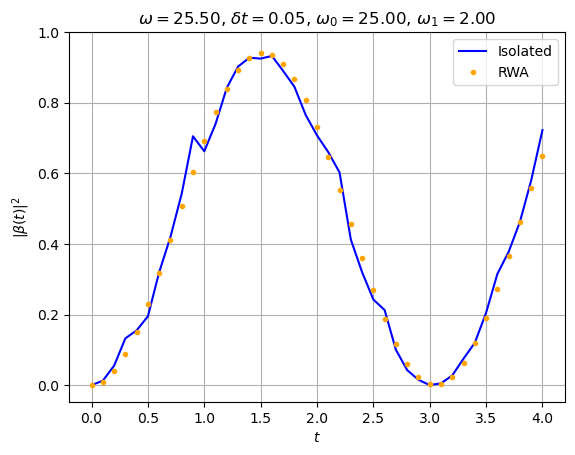

In [41]:
dt, w, w0, w1 = 0.05, 25.5, 25, 2
ts = np.arange(0, 4 + 0.1, 0.1)
plot_β_time_evolution(ts, dt, w, w0, w1, plot_rwa=True)

**(b)**

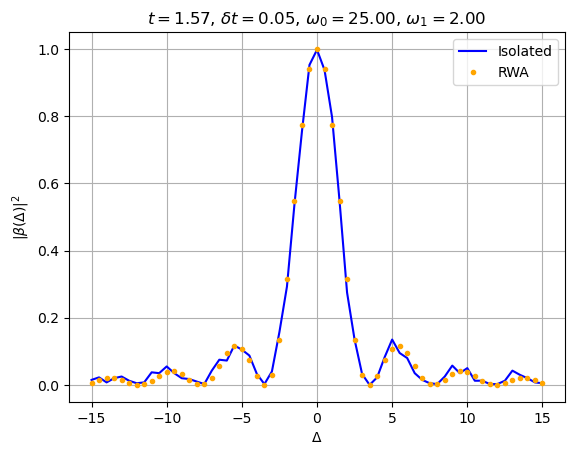

In [42]:
dt, w0, w1 = 0.05, 25, 2
t = np.pi/w1
ws = np.arange(10, 40 + 0.5, 0.5)
plot_β_frequency_spectrum(t, dt, ws, w0, w1, plot_rwa=True)

**(c)**

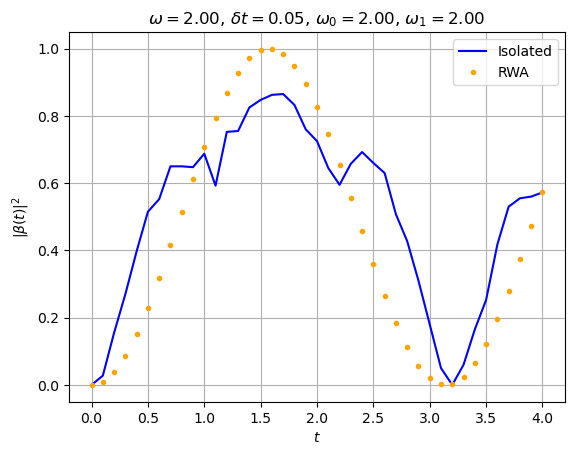

In [43]:
dt, w, w0, w1 = 0.05, 2, 2, 2
ts = np.arange(0, 4 + 0.1, 0.1)
plot_β_time_evolution(ts, dt, w, w0, w1, plot_rwa=True)

$\implies$ RWA is only a valid approximation in the regime $\omega_{1} << \omega_{0}$ and $\Delta = \omega-\omega_{0}\approx 0$

**Exercise 6 + 7**

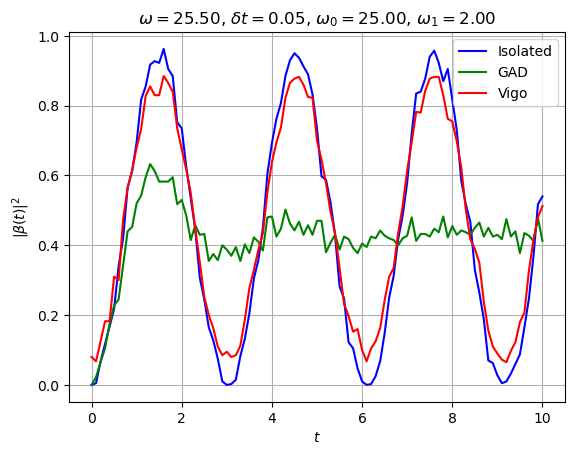

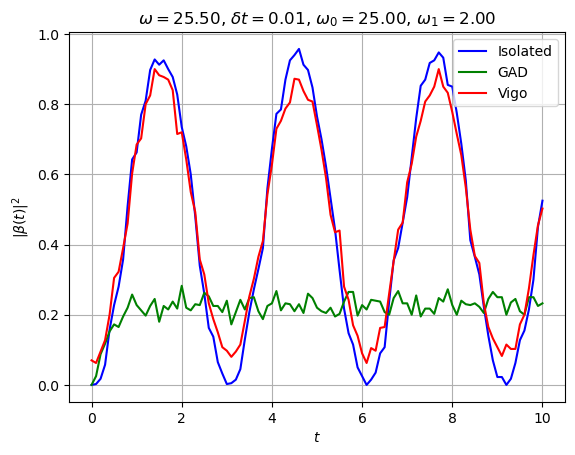

In [44]:
dt, w, w0, w1 = 0.05, 25.5, 25, 2
ts = np.arange(0, 10 + 0.1, 0.1)

# configure GAD noise model
γ, p = 0.02, 0.1
gad = NoiseModel()
error = amplitude_damping_error(γ, p)
gad.add_all_qubit_quantum_error(error, ['rx', 'rz'])

plot_β_time_evolution(ts, dt, w, w0, w1, noise_models=[gad, 'vigo'])
dt = 0.01
plot_β_time_evolution(ts, dt, w, w0, w1, noise_models=[gad, 'vigo'])

Since the error channel is applied after every gate and the circuit length increases for smaller $\delta t$, the impact of decoherence (in particular spontaneaous emission) on the quantum computation is more severe for smaller $\delta t$. In fact, for $\delta t=0.01$, no oscillation can be observed anymore, but the steady state solution is reached almost immediately. In contrast, for $\delta t=0.05$, we still see an exponentially damped oscillation.

Interestingly, Vigor seems to be quite resistant against decoherence effects.

**Exercise 8**

In [45]:
def measure(circ, basis: str, qubit, bit):
    assert basis in ['x', 'y', 'z']
    if basis=='y':
        circ.sdg(qubit)
    if basis!='z':
        circ.h(qubit)
    circ.measure(qubit, bit)      

**Exercise 9**

In [46]:
def my_StateTomography(circ, N_shots=1024):

    bloch_vector = list()
    for basis in ['x', 'y', 'z']:

        circ_copy = circ.copy()
        measure(circ_copy, basis, 0, 0)
        
        sim = AerSimulator()
        result = sim.run(circ_copy, shots=N_shots).result()
        counts = result.get_counts(circ_copy)
        bloch_vector.append(counts.get('0', 0) * 2 / N_shots - 1)

    bloch_vector /= np.linalg.norm(bloch_vector)
    nx, ny, nz = bloch_vector
    α = np.sqrt((1+nz)/2)
    φ = np.angle((nx+1.j*ny)/2)
    β = np.sqrt((1-nz)/2)*np.exp(1.j*φ)

    return Statevector([α, β])

In [47]:
circ = QuantumCircuit(1,1)
circ.h(0)
circ.t(0)
ψ = Statevector.from_instruction(circ)
ψ

Statevector([0.70710678+0.j , 0.5       +0.5j],
            dims=(2,))


In [48]:
sim = AerSimulator()
result = StateTomography(ψ, backend=sim).run()
ρ = result.analysis_results()[0].value
ρ.to_statevector(1e-1)

Statevector([0.70852362+0.j        , 0.4911506 +0.50672021j],
            dims=(2,))


Which is coincides with the input state up to a global phase $e^{-i\pi/4}$

In [49]:
my_StateTomography(circ)

Statevector([0.69211117+0.j        , 0.51826143+0.50238155j],
            dims=(2,))


**Exercise 10**

In [50]:
def plot_αβ_time_evolution_from_tomography(ts, dt, w, w0, w1, noise_models=[], plot_rwa=False, N_shots=400):

    fig, ax = plt.subplots(1, 1)
    for noise in [None] + noise_models:

        αs, βs = list(), list()
        for t in ts:

            circ = QuantumCircuit(1, 1)
            circ.initialize('0', 0)
            circ = time_evolve(circ, t, dt, w, w0, w1)
            
            α, β = my_StateTomography(circ)
            αs.append(np.absolute(α)**2)
            βs.append(np.absolute(β)**2)

        if noise == None:
            ax.plot(ts, αs, '-', label='$|\\alpha(t)|^{2}$ Isolated', color='tab:blue')
            ax.plot(ts, βs, '-', label='$|\\beta(t)|^{2}$ Isolated', color='blue')
        elif noise == 'vigo':
            ax.plot(ts, αs, '-', label='$|\\alpha(t)|^{2}$ Vigo', color='tab:red')
            ax.plot(ts, βs, '-', label='$|\\beta(t)|^{2}$ Vigo', color='red')
        else:
            ax.plot(ts, βs, '-', label='$|\\alpha(t)|^{2}$ GAD', color='tab:green')
            ax.plot(ts, βs, '-', label='$|\\beta(t)|^{2}$ GAD', color='green')

    if plot_rwa:        
        Δ = w - w0
        Ω = np.sqrt(w1**2 + Δ**2)
        αs = np.cos(Ω*ts/2)**2 + (Δ/Ω*np.sin(Ω*ts/2))**2
        βs = (w1/Ω*np.sin(Ω*ts/2))**2
        ax.plot(ts, αs, '.', label='$|\\alpha(t)|^{2}$ RWA', color='gold')
        ax.plot(ts, βs, '.', label='$|\\beta(t)|^{2}$ RWA', color='orange')

    ax.set_yticks(np.arange(0, 1 + 0.2, 0.2))
    ax.set_title('$\omega=%.2f$, $\delta t=%.2f$, $\omega_{0}=%.2f$, $\omega_{1}=%.2f$'%(w, dt, w0, w1))
    ax.set_xlabel("$t$")
    ax.legend()
    ax.grid()

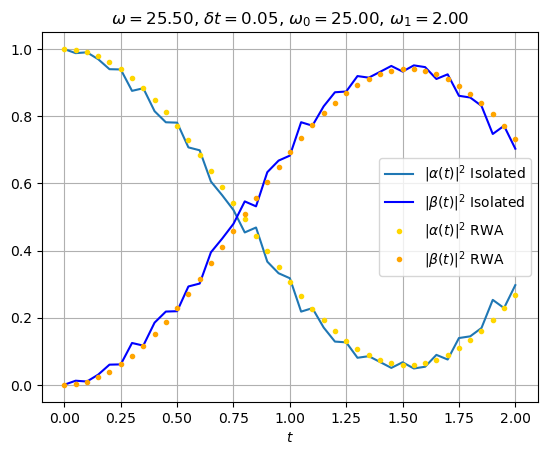

In [51]:
dt, w, w0, w1 = 0.05, 25.5, 25, 2
ts = np.arange(0, 2 + 0.05, 0.05)
plot_αβ_time_evolution_from_tomography(ts, dt, w, w0, w1, plot_rwa=True)

In [52]:
def plot_αβ_phase_time_evolution_from_tomography(ts, dt, w, w0, w1, noise_models=[], plot_rwa=False, N_shots=400):

    fig, ax = plt.subplots(1, 1)
    for noise in [None] + noise_models:

        αs, βs = list(), list()
        for t in ts:

            circ = QuantumCircuit(1, 1)
            circ.initialize('0', 0)
            circ = time_evolve(circ, t, dt, w, w0, w1)
            
            α, β = my_StateTomography(circ)
            αs.append(np.angle(α))
            βs.append(np.angle(β))

        if noise == None:
            ax.plot(ts, np.array(βs)-np.array(αs), '-', label='$|\phi(\\beta(t))-\phi(\\alpha(t))|^{2}$ Isolated', color='tab:blue')
        elif noise == 'vigo':
            ax.plot(ts, np.array(βs)-np.array(αs), '-', label='$|\phi(\\beta(t))-\phi(\\alpha(t))|^{2}$ Vigo', color='tab:red')
        else:
            ax.plot(ts, np.array(βs)-np.array(αs), '-', label='$|\phi(\\beta(t))-\phi(\\alpha(t))|^{2}$ GAD', color='tab:green')

    if plot_rwa:
        Δ = w - w0
        Ω = np.sqrt(w1**2 + Δ**2)
        αs = np.angle((np.cos(Ω*ts/2) - Δ/Ω*np.sin(Ω*ts/2)*1.j)*np.exp(1.j*w*ts/2))
        βs = np.angle((-w1/Ω*np.sin(Ω*ts/2)*1.j)*np.exp(-1.j*w*ts/2))

        ax.plot(ts, np.array(βs)-np.array(αs), '.', label='$|\phi(\\beta(t))-\phi(\\alpha(t))|^{2}$ RWA', color='orange')

    #ax.set_yticks(np.arange(0, 1 + 0.2, 0.2))
    ax.set_title('$\omega=%.2f$, $\delta t=%.2f$, $\omega_{0}=%.2f$, $\omega_{1}=%.2f$'%(w, dt, w0, w1))
    ax.set_xlabel("$t$")
    ax.legend()
    ax.grid()

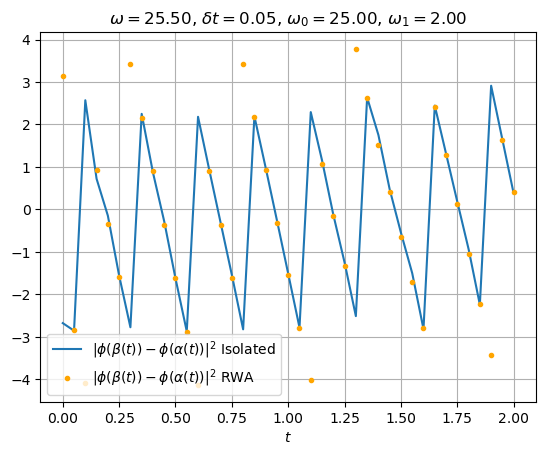

In [53]:
dt, w, w0, w1 = 0.05, 25.5, 25, 2
ts = np.arange(0, 2 + 0.05, 0.05)
plot_αβ_phase_time_evolution_from_tomography(ts, dt, w, w0, w1, plot_rwa=True)

**Exercise 11**

In [54]:
def prepare_trial(a, b):
    circ = QuantumCircuit(2, 2)
    circ.rzx(-2*b, 0, 1)
    circ.rzx(-2*b, 1, 0)
    circ.rz(-2*a, 0)
    circ.rz(-2*a, 1)
    return circ

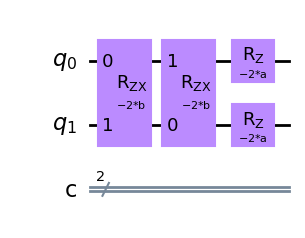

In [55]:
a, b = Parameter('a'), Parameter('b')
circ =prepare_trial(a, b)
circ.draw(output='mpl')

**Exercise 12**

In [88]:
def grid_search(a_grid, b_grid, noise=None, shots=100):

    # observable = SparsePauliOp.from_list([("XZ", -1), ("ZX", -1)])

    energies = np.zeros((len(a_grid), len(a_grid)))
    for i, a in enumerate(a_grid):
        for j, b in enumerate(b_grid):

            circ_xz = prepare_trial(a, b)
            circ_zx =  circ_xz.copy()

            measure(circ_xz, 'x', 0, 0)
            measure(circ_xz, 'z', 1, 1)
            sim = AerSimulator(noise_model=noise)
            counts = sim.run(circ_xz, shots=shots).result().get_counts(circ_xz)
            xz = (counts.get('00', 0) + counts.get('11', 0) - counts.get('10', 0) - counts.get('01', 0)) / shots

            measure(circ_zx, 'x', 1, 1)
            measure(circ_zx, 'z', 0, 0)
            sim = AerSimulator(noise_model=noise)
            counts = sim.run(circ_zx, shots=shots).result().get_counts(circ_zx)
            zx = (counts.get('00', 0) + counts.get('11', 0) - counts.get('10', 0) - counts.get('01', 0)) / shots

            energy = - xz -  zx

            # circ = prepare_trial(a, b)
            # estimator = Estimator()
            # energy = estimator.run(circ, observable, noise=noise, shots=shots).result().values

            energies[i, j] = energy

    return energies

Minimum energy is at a=2.31, b=2.31 with E_min=-2.00


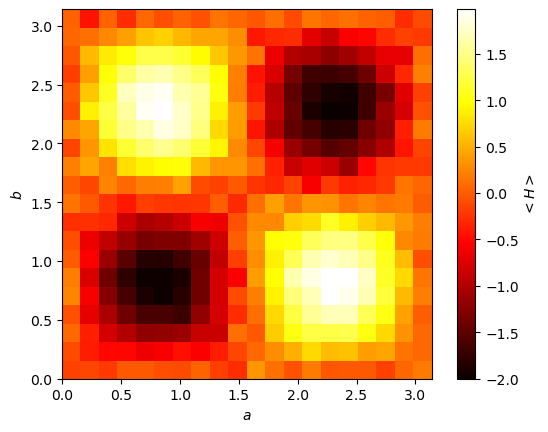

In [89]:
# run grid search
a_grid = b_grid = np.linspace(0, np.pi, 20)
energies = grid_search(a_grid, b_grid)

# plot energy expectation landscape
fig, ax = plt.subplots(1, 1)
img = ax.imshow(energies, extent=[0, np.pi, 0, np.pi], origin='lower', cmap='hot')
plt.colorbar(img, ax=ax, label='$<H>$')
ax.set_xlabel('$a$'), ax.set_ylabel('$b$')

# find groundstate
i, j = np.unravel_index(energies.argmin(), energies.shape)
E_min, a_min, b_min = energies[i, j], a_grid[i], b_grid[j]
print('Minimum energy is at a=%.2f, b=%.2f with E_min=%.2f'%(a_min, b_min, E_min))

In [90]:
circ = prepare_trial(a_min, b_min)
# compare to analytic solution by computing inner product
exact_groundstate = Statevector(np.array([1, 1, 1, -1])/2)
np.absolute(Statevector.from_instruction(circ).inner(exact_groundstate))

0.9965903258506806

**Exercise 14**

Minimum energy is at a=0.66, b=0.83 with E_min=-1.42


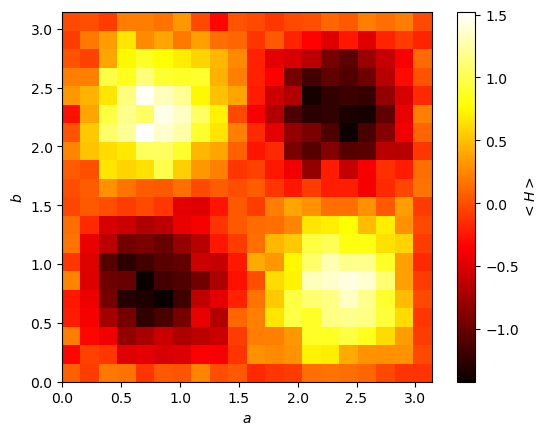

In [94]:
# configure GAD noise
noise = NoiseModel()
γ = 0.1
p = 0.2
error = amplitude_damping_error(γ, p)
noise.add_all_qubit_quantum_error(error, ['rz'])#, 'h', 'measure'])
noise.add_all_qubit_quantum_error(error.tensor(error), ['rzx'])

# run grid search
a_grid = b_grid = np.linspace(0, np.pi, 20)
energies = grid_search(a_grid, b_grid, noise=noise)

# plot energy expectation landscape
fig, ax = plt.subplots(1, 1)
img = ax.imshow(energies, extent=[0, np.pi, 0, np.pi], origin='lower', cmap='hot')
plt.colorbar(img, ax=ax, label='$<H>$')
ax.set_xlabel('$a$'), ax.set_ylabel('$b$')

# find groundstate
i, j = np.unravel_index(energies.argmin(), energies.shape)
E_min, a_min, b_min = energies[i, j], a_grid[i], b_grid[j]
print('Minimum energy is at a=%.2f, b=%.2f with E_min=%.2f'%(a_min, b_min, E_min))

In [92]:
circ = prepare_trial(a_min, b_min)
# compare to analytic solution by computing inner product
exact_groundstate = Statevector(np.array([1, 1, 1, -1])/2)
np.absolute(Statevector.from_instruction(circ).inner(exact_groundstate))

0.9830446362758394